In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data_folder = "/content/drive/MyDrive/ml/data"
root_folder = "/content/drive/MyDrive/ml"

In [ ]:
# data_folder = "data"

In [ ]:
!pip install tensorflow_addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 10.5 MB/s eta 0:00:00


In [ ]:
import random
import os
import numpy as np
import cv2
import pandas as pd
from sklearn.model_selection import train_test_split

import itertools
import keras.models
import keras.callbacks
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, Lambda
from keras.optimizers import RMSprop,Adam, SGD
import tensorflow as tf
import sklearn.metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from copy import deepcopy
from tensorflow_addons.layers import WeightNormalization  # Import WeightNormalization layer



/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [ ]:
print(tf.config.list_physical_devices('CPU'))


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


In [ ]:
tf.test.is_built_with_cuda()


True

In [ ]:
width = 384
height = width

In [ ]:
def sp_noise(image,prob):
    '''
    Add salt and pepper noise to image
    prob: Probability of the noise
    '''
    output = np.zeros(image.shape,np.uint8)
    thres = 1 - prob
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            rdn = random.random()
            if rdn < prob:
                output[i][j] = 0
            elif rdn > thres:
                output[i][j] = 255
            else:
                output[i][j] = image[i][j]
    return output


In [ ]:
combwrench_folder = f"{data_folder}/CombWrench"
combwrench_real_files = [f for f in os.listdir(combwrench_folder) if f.endswith('.png') or f.endswith('.JPEG')]

hammer_folder = f"{data_folder}/Hammer"
hammer_real_files = [f for f in os.listdir(hammer_folder) if f.endswith('.png') or f.endswith('.JPEG')]

screwdriver_folder = f"{data_folder}/Screwdriver"
screwdriver_real_files = [f for f in os.listdir(screwdriver_folder) if f.endswith('.png') or f.endswith('.JPEG')]

wrench_folder = f"{data_folder}/Wrench"
wrench_real_files = [f for f in os.listdir(wrench_folder) if f.endswith('.png') or f.endswith('.JPEG')]

# Extra generated files
combwrench_extra_folder = f"{data_folder}/CombWrenchExtra"
combwrench_extra_files = [f for f in os.listdir(combwrench_extra_folder) if f.endswith('.png') or f.endswith('.JPEG') or f.endswith('.jpg')]

hammer_extra_folder = f"{data_folder}/HammerExtra"
hammer_extra_files = [f for f in os.listdir(hammer_extra_folder) if f.endswith('.png') or f.endswith('.JPEG') or f.endswith('.jpg')]

screwdriver_extra_folder = f"{data_folder}/ScrewdriverExtra"
screwdriver_extra_files = [f for f in os.listdir(screwdriver_extra_folder) if f.endswith('.png') or f.endswith('.JPEG') or f.endswith('.jpg')]

wrench_extra_folder = f"{data_folder}/WrenchExtra"
wrench_extra_files = [f for f in os.listdir(wrench_extra_folder) if f.endswith('.png') or f.endswith('.JPEG') or f.endswith('.jpg')]

#Synthetic files
combwrench_fake_folder = f"{data_folder}/CombWrenchSynth"
combwrench_fake_files = [f for f in os.listdir(combwrench_fake_folder) if f.endswith('.png') or f.endswith('.JPEG')]
combwrench_fake_files = combwrench_fake_files[:600]

hammer_fake_folder = f"{data_folder}/HammerSynth"
hammer_fake_files = [f for f in os.listdir(hammer_fake_folder) if f.endswith('.png') or f.endswith('.JPEG')]
hammer_fake_files = hammer_fake_files[:600]

screwdriver_fake_folder = f"{data_folder}/ScrewdriverSynth"
screwdriver_fake_files = [f for f in os.listdir(screwdriver_fake_folder) if f.endswith('.png') or f.endswith('.JPEG')]
screwdriver_fake_files = screwdriver_fake_files[:600]

wrench_fake_folder = f"{data_folder}/WrenchSynth"
wrench_fake_files = [f for f in os.listdir(wrench_fake_folder) if f.endswith('.png') or f.endswith('.JPEG')]
wrench_fake_files = wrench_fake_files[:600]

In [ ]:
print(len(combwrench_real_files))
print(len(hammer_real_files))
print(len(screwdriver_real_files))
print(len(wrench_real_files))

# print(len(combwrench_extra_files))
# print(len(hammer_extra_files))
# print(len(screwdriver_extra_files))
# print(len(wrench_extra_files))

52
51
50
50


In [ ]:
import matplotlib.pyplot as plt


In [ ]:
def processReal(width: int, height: int, fileNames: list, imagelist: list, type: str, showImg: bool):
    print(f"{type} images: {len(fileNames)}")

    for count, file in enumerate(fileNames):
        print(f"[{count+1}/{len(fileNames)}] Opening image {data_folder}/{type}/{file}")
        image = cv2.imread(f"{data_folder}/{type}/{file}")

        if image is None:
            print(f"Error: Unable to open image {file}")
            continue

        image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image_normalized = image_gray #cv2.normalize(image_gray, None, 0, 1, cv2.NORM_MINMAX)
        image_resized = cv2.resize(image_normalized, (width, height))
        image_resized = sp_noise(image_resized, 0.05)
        # Append the original image

        # Generate rotated images and apply shearing
        for angle in range(4):
            image_resized = cv2.rotate(image_resized, cv2.ROTATE_90_CLOCKWISE)
            imagelist.append(cv2.normalize(image_resized, None, 0, 1.0, cv2.NORM_MINMAX, dtype=cv2.CV_32F))

            # if image_resized is None:
            #     continue

            # img_copy = deepcopy(image_resized)

            #  # Randomize shear direction and factor
            # shear_factor_x = random.uniform(0.35, 0.8)  # Random shear factor for x direction
            # shear_factor_y = random.uniform(0.35, 0.8)  # Random shear factor for y direction

            # shear_x = random.choice([True, False])      # Randomly choose whether to shear in x direction
            # shear_y = random.choice([True, False])      # Randomly choose whether to shear in y direction

            # while not shear_x and not shear_y:
            #     shear_x = random.choice([True, False])      # Randomly choose whether to shear in x direction
            #     shear_y = random.choice([True, False])      # Randomly choose whether to shear in y direction

            # new_width = width + int(height * np.abs(shear_x))
            # new_height = height + int(width * np.abs(shear_y))

            # if shear_x:
            #     M_shear_x = np.float32([[1, shear_factor_x, 0], [0, 1, 0]])

            #     if shear_y:
            #         img_copy = cv2.warpAffine(img_copy, M_shear_x, (new_width, new_height))
            #     else:
            #         img_copy = cv2.warpAffine(img_copy, M_shear_x, (new_width, height))

            # if shear_y:
            #     M_shear_y = np.float32([[1, 0, 0], [shear_factor_y, 1, 0]])

            #     if shear_x:
            #         img_copy = cv2.warpAffine(img_copy, M_shear_y, (new_width, new_height))
            #     else:
            #         img_copy = cv2.warpAffine(img_copy, M_shear_y, (width, new_height))

            # img_copy = cv2.resize(img_copy, (width, height))

            # if showImg:
            #   plt.imshow(img_copy, cmap='gray')  # Assuming img_copy is a grayscale image
            #   plt.axis('off')  # Turn off axis
            #   plt.show()  # Display the image


            # sheared_image_normalized = cv2.normalize(img_copy, None, 0, 1.0, cv2.NORM_MINMAX, dtype=cv2.CV_32F)
            # imagelist.append(sheared_image_normalized)

In [ ]:

def processFake(width: int, height: int, fileNames: list, imagelist: list, type: str):
    print(f"{type} images: {len(fileNames)}")

    for count, file in enumerate(fileNames):
        print(f"[{count}/{len(fileNames)}] opening image {data_folder}/{type}Synth/{file}")
        image = cv2.imread(f"{data_folder}/{type}Synth/{file}")

        if image is None:
            print(f"Error: Unable to open image {file}")
            continue

        image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image_normalized = image_gray #cv2.normalize(image_gray, None, 0, 1, cv2.NORM_MINMAX)
        image_resized = cv2.resize(image_normalized, (width, height))
        image_resized = sp_noise(image_resized, 0.1)
        # Append the original image
        imagelist.append(cv2.normalize(image_resized, None, 0, 1, cv2.NORM_MINMAX, dtype=cv2.CV_32F))


In [ ]:
def processExtra(width: int, height: int, fileNames: list, imagelist: list, type: str, showImg: bool):
    print(f"{type} images: {len(fileNames)}")

    for count, file in enumerate(fileNames):
        print(f"[{count+1}/{len(fileNames)}] Opening image {data_folder}/{type}Extra/{file}")
        image = cv2.imread(f"{data_folder}/{type}Extra/{file}")

        if image is None:
            print(f"Error: Unable to open image {file}")
            continue

        image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image_normalized = image_gray #cv2.normalize(image_gray, None, 0, 1, cv2.NORM_MINMAX)
        image_resized = cv2.resize(image_normalized, (width, height))
        image_resized = sp_noise(image_resized, 0.05)

        # Generate rotated images
        for angle in range(4):
            image_resized = cv2.rotate(image_resized, cv2.ROTATE_90_CLOCKWISE)
            imagelist.append(cv2.normalize(image_resized, None, 0, 1, cv2.NORM_MINMAX, dtype=cv2.CV_32F))



In [ ]:
import threading

combWrenches = []
hammers = []
screwdriver = []
wrench = []

t1 = threading.Thread(target=processReal, args= [width, height, combwrench_real_files, combWrenches, "CombWrench", False])
t2 = threading.Thread(target=processReal, args= [width, height, hammer_real_files, hammers, "Hammer", False])
t3 = threading.Thread(target=processReal, args= [width, height, screwdriver_real_files, screwdriver, "Screwdriver", False])
t4 = threading.Thread(target=processReal, args= [width, height, wrench_real_files, wrench, "Wrench", False])

t1.start()
t2.start()
t3.start()
t4.start()

t1.join()
t2.join()
t3.join()
t4.join()


CombWrench images: 52
[1/52] Opening image /content/drive/MyDrive/ml/data/CombWrench/IMG_0602.JPEG
Hammer images: 51
[1/51] Opening image /content/drive/MyDrive/ml/data/Hammer/IMG_0657.JPEG
Screwdriver images: 50
[1/50] Opening image /content/drive/MyDrive/ml/data/Screwdriver/IMG_0513.JPEG
Wrench images: 50
[1/50] Opening image /content/drive/MyDrive/ml/data/Wrench/17.png
[2/52] Opening image /content/drive/MyDrive/ml/data/CombWrench/IMG_0605.JPEG
[2/50] Opening image /content/drive/MyDrive/ml/data/Wrench/12.png
[2/51] Opening image /content/drive/MyDrive/ml/data/Hammer/IMG_0663.JPEG
[2/50] Opening image /content/drive/MyDrive/ml/data/Screwdriver/IMG_0516.JPEG
[3/51] Opening image /content/drive/MyDrive/ml/data/Hammer/IMG_0670.JPEG
[3/52] Opening image /content/drive/MyDrive/ml/data/CombWrench/IMG_0604.JPEG
[3/50] Opening image /content/drive/MyDrive/ml/data/Wrench/13.png
[3/50] Opening image /content/drive/MyDrive/ml/data/Screwdriver/IMG_0511.JPEG
[4/51] Opening image /content/drive/M

In [ ]:
print(len(combWrenches))
print(len(hammers))
print(len(screwdriver))
print(len(wrench))

208
204
200
200


In [ ]:
t1 = threading.Thread(target=processFake, args= [width, height, combwrench_fake_files, combWrenches, "CombWrench"])
t2 = threading.Thread(target=processFake, args= [width, height, hammer_fake_files, hammers, "Hammer"])
t3 = threading.Thread(target=processFake, args= [width, height, screwdriver_fake_files, screwdriver, "Screwdriver"])
t4 = threading.Thread(target=processFake, args= [width, height, wrench_fake_files, wrench, "Wrench"])


t1.start()
t2.start()
t3.start()
t4.start()

t1.join()
t2.join()
t3.join()
t4.join()

CombWrench images: 600
[0/600] opening image /content/drive/MyDrive/ml/data/CombWrenchSynth/13136_img.png
Hammer images: 600
[0/600] opening image /content/drive/MyDrive/ml/data/HammerSynth/1327_img.png
Screwdriver images: 600
[0/600] opening image /content/drive/MyDrive/ml/data/ScrewdriverSynth/390_img.png
Wrench images: 600
[0/600] opening image /content/drive/MyDrive/ml/data/WrenchSynth/1712_img.png
[1/600] opening image /content/drive/MyDrive/ml/data/CombWrenchSynth/13137_img.png
[1/600] opening image /content/drive/MyDrive/ml/data/WrenchSynth/17233_img.png
[1/600] opening image /content/drive/MyDrive/ml/data/ScrewdriverSynth/3912_img.png
[1/600] opening image /content/drive/MyDrive/ml/data/HammerSynth/13291_img.png
[2/600] opening image /content/drive/MyDrive/ml/data/CombWrenchSynth/13140_img.png
[2/600] opening image /content/drive/MyDrive/ml/data/WrenchSynth/17398_img.png
[2/600] opening image /content/drive/MyDrive/ml/data/ScrewdriverSynth/3913_img.png
[2/600] opening image /co

In [ ]:
extra_combWrenches = []
extra_hammers = []
extra_screwdriver = []
extra_wrench = []

t1 = threading.Thread(target=processExtra, args= [width, height, combwrench_extra_files, extra_combWrenches, "CombWrench", False])
t2 = threading.Thread(target=processExtra, args= [width, height, hammer_extra_files, extra_hammers, "Hammer", False])
t3 = threading.Thread(target=processExtra, args= [width, height, screwdriver_extra_files, extra_screwdriver, "Screwdriver", False])
t4 = threading.Thread(target=processExtra, args= [width, height, wrench_extra_files, extra_wrench, "Wrench", False])

t1.start()
t2.start()
t3.start()
t4.start()

t1.join()
t2.join()
t3.join()
t4.join()

CombWrench images: 19
[1/19] Opening image /content/drive/MyDrive/ml/data/CombWrenchExtra/generated_combwrench (3).jpg
Hammer images: 20
[1/20] Opening image /content/drive/MyDrive/ml/data/HammerExtra/generated_hammer (16).jpg
Screwdriver images: 20
[1/20] Opening image /content/drive/MyDrive/ml/data/ScrewdriverExtra/generated_screwdriver (14).jpg
Wrench images: 20
[1/20] Opening image /content/drive/MyDrive/ml/data/WrenchExtra/generated_wrench (4).jpg
[2/20] Opening image /content/drive/MyDrive/ml/data/ScrewdriverExtra/generated_screwdriver (6).jpg
[2/20] Opening image /content/drive/MyDrive/ml/data/WrenchExtra/generated_wrench (14).jpg[2/20] Opening image /content/drive/MyDrive/ml/data/HammerExtra/generated_hammer (19).jpg

[2/19] Opening image /content/drive/MyDrive/ml/data/CombWrenchExtra/generated_combwrench (19).jpg
[3/20] Opening image /content/drive/MyDrive/ml/data/WrenchExtra/generated_wrench (7).jpg
[3/19] Opening image /content/drive/MyDrive/ml/data/CombWrenchExtra/generated

In [ ]:
print(len(extra_combWrenches))
print(len(extra_hammers))
print(len(extra_screwdriver))
print(len(extra_wrench))

76
80
80
80


In [ ]:
imagedict = {}

random.shuffle(combWrenches)
random.shuffle(hammers)
random.shuffle(screwdriver)
random.shuffle(wrench)

random.shuffle(extra_combWrenches)
random.shuffle(extra_hammers)
random.shuffle(extra_screwdriver)
random.shuffle(extra_wrench)

imagedict['CombWrench'] = combWrenches
imagedict['Hammer'] = hammers
imagedict['Screwdriver'] = screwdriver
imagedict['Wrench'] = wrench

imagedict['CombWrench'] += extra_combWrenches
imagedict['Hammer']+= extra_hammers
imagedict['Screwdriver']+= extra_screwdriver
imagedict['Wrench']+= extra_wrench

In [ ]:
print(len(imagedict['CombWrench']))
print(len(imagedict['Hammer']))
print(len(imagedict['Screwdriver']))
print(len(imagedict['Wrench']))

884
884
880
880


In [ ]:
combined_df = pd.DataFrame()
combined_df['imgdata'] = []
combined_df['label'] = ''

for comb, hammer, screw, wrench in zip(imagedict['CombWrench'], imagedict['Hammer'], imagedict['Screwdriver'], imagedict['Wrench']):

  row = list()
  imgdata = comb
  row.append(imgdata)
  row.append('combwrench')
  combined_df = pd.concat([pd.DataFrame([row], columns=['imgdata', 'label']), combined_df])

  row = list()
  imgdata = hammer
  row.append(imgdata)
  row.append('hammer')
  combined_df = pd.concat([pd.DataFrame([row], columns=['imgdata', 'label']), combined_df])

  row = list()
  imgdata = screw
  row.append(imgdata)
  row.append('screwdriver')
  combined_df = pd.concat([pd.DataFrame([row], columns=['imgdata', 'label']), combined_df])

  row = list()
  imgdata = wrench
  row.append(imgdata)
  row.append('wrench')
  combined_df = pd.concat([pd.DataFrame([row], columns=['imgdata', 'label']), combined_df])



combined_df.head()

,imgdata,label
0,"[[0.24313727, 1.0, 0.2392157, 0.2392157, 0.235...",wrench
0,"[[0.10588236, 0.10588236, 0.10588236, 0.109803...",screwdriver
0,"[[0.15294118, 0.15294118, 0.15294118, 0.156862...",hammer
0,"[[0.03529412, 0.039215688, 1.0, 0.03529412, 0....",combwrench
0,"[[0.0, 0.22352943, 0.23529413, 0.24705884, 0.2...",wrench


# Creating a train/test split


In [ ]:
X = combined_df.drop(columns=['label'],axis = 1)
Y = combined_df['label']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state=None)

for index, row in X_train.iterrows():
  row['imgdata'] = row['imgdata'].reshape(height,width,1)


for index, row in X_test.iterrows():
  row['imgdata'] = row['imgdata'].reshape(height,width,1)

In [ ]:

with tf.device('GPU:0'):

    callback = keras.callbacks.EarlyStopping(monitor="loss", patience=10)
    model = Sequential()
    model.add(Lambda(lambda x: tf.cast(x, tf.float32), input_shape=(height, width, 1)))

    model.add(WeightNormalization(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(height, width, 1))))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2, 2)))

    model.add(WeightNormalization(Conv2D(64, (3, 3), padding='same', activation='relu')))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2, 2)))

    model.add(WeightNormalization(Conv2D(64, (3, 3), padding='same', activation='relu')))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(384, activation='relu'))
    model.add(Dropout(0.2))

    model.add(Dense(4, activation = "softmax"))

In [ ]:
optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

In [ ]:
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In [ ]:
epochs = 800
batch_size = 50

In [ ]:
labels = {'screwdriver': 0, 'combwrench': 1, 'hammer': 2, 'wrench': 3}
import array as arr


X_train_arr = []
for img in X_train['imgdata']:
  X_train_arr.append(img)

X_train_arr = np.array(X_train_arr)

Y_train_arr = []
for label in Y_train[0]:
  arr = [0,0,0,0]
  arr[labels[label]] = 1
  Y_train_arr.append(arr)

Y_train_arr = np.array(Y_train_arr)

X_test_arr = []
for img in X_test['imgdata']:
  X_test_arr.append(img)

X_test_arr = np.array(X_test_arr)

Y_test_arr = []
for label in Y_test[0]:
  arr = [0,0,0,0]
  arr[labels[label]] = 1
  Y_test_arr.append(arr)

Y_test_arr = np.array(Y_test_arr)


In [ ]:
tf.config.experimental_run_functions_eagerly(True)
tf.data.experimental.enable_debug_mode()

Instructions for updating:
Use `tf.config.run_functions_eagerly` instead of the experimental version.


In [ ]:
with tf.device('GPU:0'):
    history = model.fit(
        X_train_arr,
        Y_train_arr,
        batch_size=batch_size,
        epochs=epochs,
        verbose=1,
        validation_data=(X_test_arr,Y_test_arr),
        callbacks=callback
    )

Epoch 1/800
57/57 [==============================] - 85s 1s/step - loss: 45.6245 - accuracy: 0.2592 - val_loss: 16.3161 - val_accuracy: 0.2287
Epoch 2/800
57/57 [==============================] - 65s 1s/step - loss: 1.7870 - accuracy: 0.2848 - val_loss: 1.5181 - val_accuracy: 0.2685
Epoch 3/800
57/57 [==============================] - 65s 1s/step - loss: 1.3644 - accuracy: 0.2741 - val_loss: 1.4069 - val_accuracy: 0.2472
Epoch 4/800
57/57 [==============================] - 65s 1s/step - loss: 1.3554 - accuracy: 0.2869 - val_loss: 1.4020 - val_accuracy: 0.2401
Epoch 5/800
57/57 [==============================] - 65s 1s/step - loss: 1.3563 - accuracy: 0.2727 - val_loss: 1.4504 - val_accuracy: 0.2486
Epoch 6/800
57/57 [==============================] - 66s 1s/step - loss: 1.3281 - accuracy: 0.2962 - val_loss: 1.4556 - val_accuracy: 0.2656
Epoch 7/800
57/57 [==============================] - 66s 1s/step - loss: 1.3180 - accuracy: 0.3136 - val_loss: 1.4646 - val_accuracy: 0.2429
Epoch 8/800

KeyboardInterrupt: 

22/22 [==============================] - 7s 259ms/step
dict_keys(['screwdriver', 'combwrench', 'hammer', 'wrench'])
[[0.22666667 0.24796748 0.24409449 0.203125  ]
 [0.22666667 0.25609756 0.27559055 0.2578125 ]
 [0.34666667 0.26829268 0.27559055 0.25      ]
 [0.2        0.22764228 0.20472441 0.2890625 ]]


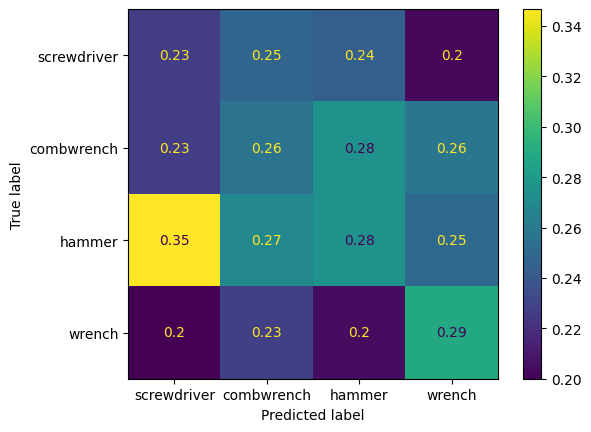

In [ ]:

y_prediction = model.predict(X_test_arr)
y_prediction = np.argmax (y_prediction, axis = 1)
y_test=np.argmax(Y_test_arr, axis=1)
#Create confusion matrix and normalizes it over predicted (columns)
print(labels.keys())
result = confusion_matrix(y_test, y_prediction, normalize='pred')
print(result)
test = sklearn.metrics.ConfusionMatrixDisplay(result,  display_labels=['screwdriver', 'combwrench', 'hammer', 'wrench'])
test.plot()

In [ ]:
folder_counter = 0
for r, d, folder in os.walk(f"{root_folder}/models/"):
    folder_counter = len(folder)

print(folder_counter)
model.save(f"{root_folder}/models/model_{folder_counter}.keras")
model.save_weights(f"{root_folder}/models/model_{folder_counter}_weights.h5")

9


In [ ]:
import keras.backend
keras.backend.clear_session()

In [ ]:
import gc

gc.collect()